# Pulsar Star Classification Problem

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
# Set color map to have light blue background
sns.set()
import altair as alt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Pulsar Stars are neutron stars that look like flickering stars from earth as they radiate two beams of steady light in opossite directions, but because they are rotating the light that gets to earth looks flickering. They are fascinating by itselves but they also have plenty of applications. They have been used to test the general relativity theory under extreme gravitational conditions, as objects to create spacial maps, to create prescise clocks, probes of interstellar medium, probes of space time and to search for gravitational waves among other things. So identifying posible pulsar stars can be of great help to astronomers and scientitis for use in such applications. 
https://en.wikipedia.org/wiki/Pulsar
https://www.space.com/32661-pulsars.html


The data of pulsar candidates comes from Kaggel and was collected during the High Time Resolution Universe Survey
https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate
It contains statistics of the collected data for each object in the universe survey with some preprocesed data to be in kaggle.  It is clearly labeled for a machine learning classification problem, which is what I will do in this notebook.

## Exploratory Data Analysis and Data Cleaning. 

First we load the data from the CSV file and change the names of the columns make it easier to deal with them. The cvs file was downloaded from 'https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate/download?datasetVersionNumber=1'


In [2]:

pulsar = pd.read_csv('Final_Project/pulsar_data_train.csv')
pulsar.columns = pulsar.columns.str.lstrip()
pulsar.columns = pulsar.columns.str.replace(' ','_')
pulsar.columns = pulsar.columns.str.replace('-','_')

Let's start the data analisys by looking at the histogram of each feature in the data. 

/var/folders/n5/yyv4zxgx3xb4rdrwt70vgb380000gn/T/ipykernel_86751/171244307.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pulsar.hist(ax = ax, bins =100);


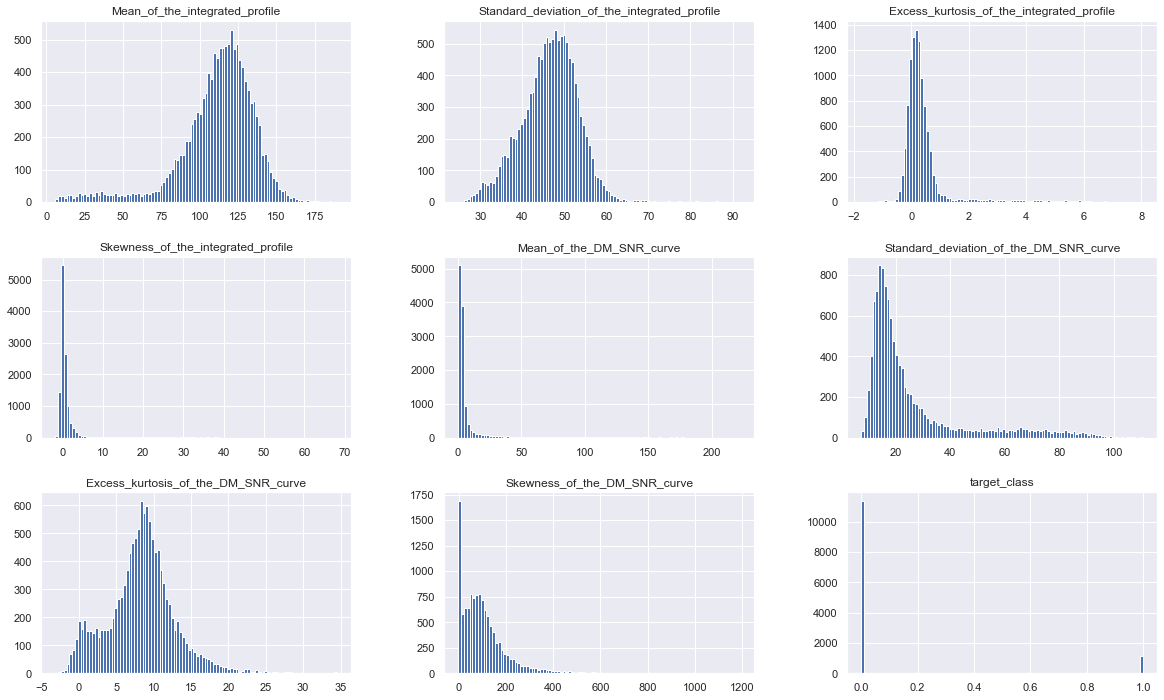

In [3]:
fig = plt.figure(figsize = (20,12))
ax = fig.gca()
pulsar.hist(ax = ax, bins =100);


From the histograms we can see there are different scales in the features, so we will probaly need to scale or regularize the features. In the target class histogram we see that the data is imbalanced. Some of the histograms are heavealy charged to the left, this makes me suspect of outliers. So i will check for them in scatter plots where the color is the target class. 

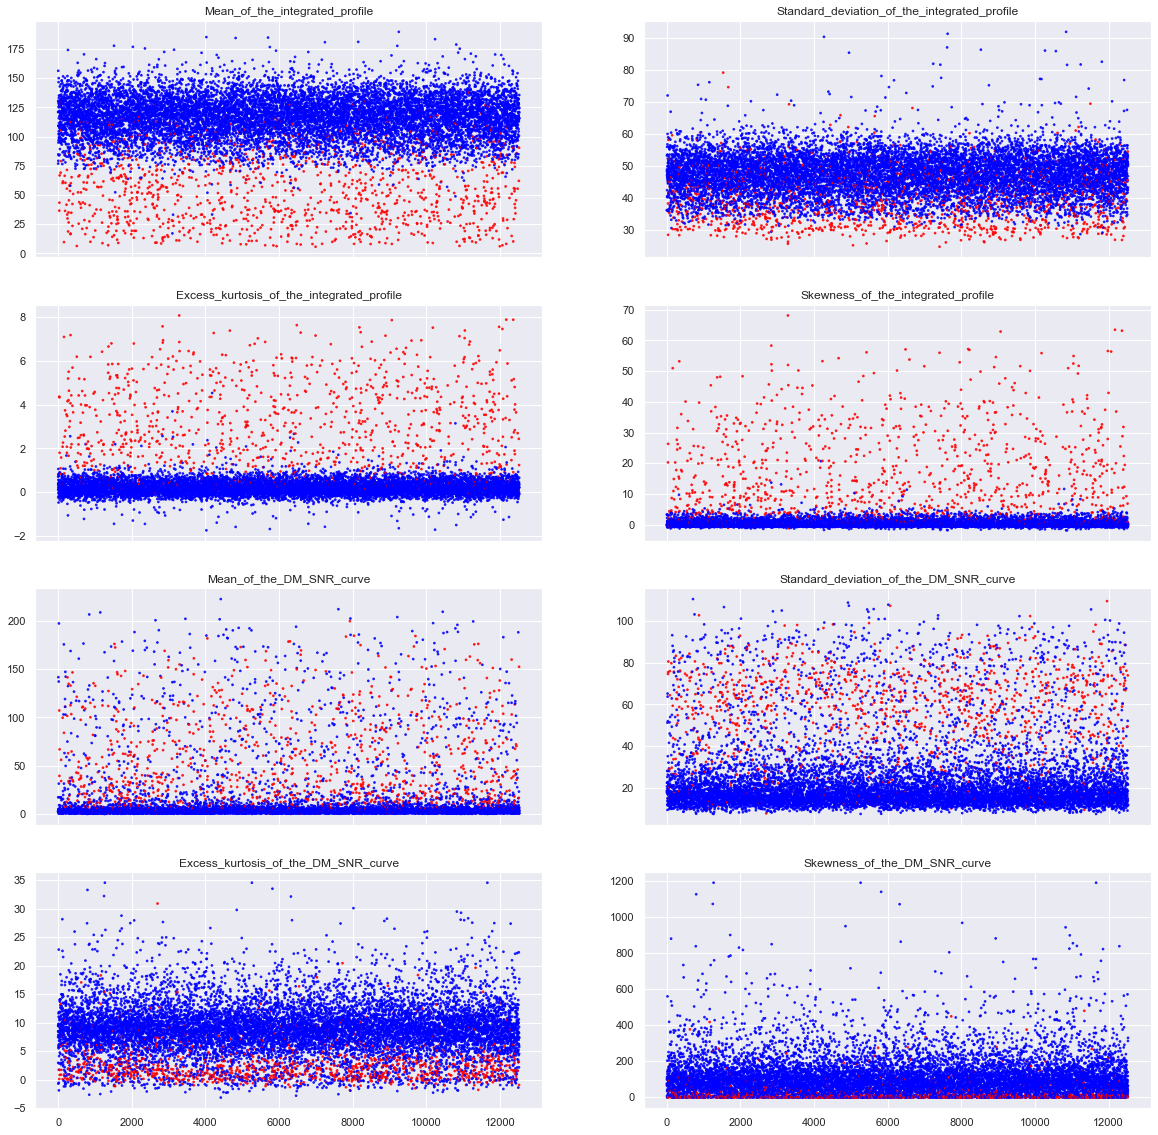

In [4]:
c = pulsar.columns.values[0:8]
x = np.arange(0,len(pulsar))
fig, axs = plt.subplots(4,2 ,sharex=True,figsize = (20,20))
axs[0, 0].scatter(x,pulsar[c[0]],c = pulsar.target_class ,s=3,cmap = 'bwr',alpha = 0.8)
axs[0, 0].set_title(c[0])
axs[0, 1].scatter(x,pulsar[c[1]],c = pulsar.target_class,s=3,cmap = 'bwr',alpha = 0.8)
axs[0, 1].set_title(c[1])
axs[1, 0].scatter(x,pulsar[c[2]],c = pulsar.target_class,s=3,cmap = 'bwr',alpha = 0.8)
axs[1, 0].set_title(c[2])
axs[1, 1].scatter(x,pulsar[c[3]],c = pulsar.target_class,s=3,cmap = 'bwr',alpha = 0.8)
axs[1, 1].set_title(c[3])
axs[2, 0].scatter(x,pulsar[c[4]],c = pulsar.target_class ,s=3,cmap = 'bwr',alpha = 0.8)
axs[2, 0].set_title(c[4])
axs[2, 1].scatter(x,pulsar[c[5]],c = pulsar.target_class,s=3,cmap = 'bwr',alpha = 0.8)
axs[2, 1].set_title(c[5])
axs[3, 0].scatter(x,pulsar[c[6]],c = pulsar.target_class ,s=3,cmap = 'bwr',alpha = 0.8)
axs[3, 0].set_title(c[6])
axs[3, 1].scatter(x,pulsar[c[7]],c = pulsar.target_class,s=3,cmap = 'bwr',alpha = 0.8)
axs[3, 1].set_title(c[7])
plt.show()


From the scatter plots we see there aren't really outliers but the data is sparse for some large values of some of the features. 

Because the scales of each feature are very different I will scale all the data using min-max scaling so every feature is between 0 and 1 and when I use methods like regression the data will be nicely scaled. This kind of scaling doesnt change the correlation between the features. 

In [5]:
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler()
p_norm = norm.fit_transform(pulsar)
p_norm = pd.DataFrame(p_norm, columns = pulsar.columns)
p_norm.describe()

,Mean_of_the_integrated_profile,Standard_deviation_of_the_integrated_profile,Excess_kurtosis_of_the_integrated_profile,Skewness_of_the_integrated_profile,Mean_of_the_DM_SNR_curve,Standard_deviation_of_the_DM_SNR_curve,Excess_kurtosis_of_the_DM_SNR_curve,Skewness_of_the_DM_SNR_curve,target_class
count,12528.000000,12528.000000,10793.000000,12528.000000,12528.000000,11350.000000,12528.000000,11903.000000,12528.000000
mean,0.572142,0.324441,0.226007,0.051082,0.056081,0.183795,0.304486,0.090113,0.092034
std,0.139586,0.101453,0.108560,0.088827,0.133268,0.189895,0.120379,0.090026,0.289085
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.516842,0.262397,0.179726,0.022946,0.007638,0.068111,0.237329,0.031163,0.000000
50%,0.594661,0.330551,0.200019,0.028546,0.011608,0.106921,0.307607,0.071337,0.000000
75%,0.659502,0.390937,0.225454,0.038977,0.023402,0.203027,0.368034,0.119009,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now let's look at the information of the data, to check exactly how many instances we have and how many null values for each feature. 

In [6]:
pulsar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Mean_of_the_integrated_profile                12528 non-null  float64
 1   Standard_deviation_of_the_integrated_profile  12528 non-null  float64
 2   Excess_kurtosis_of_the_integrated_profile     10793 non-null  float64
 3   Skewness_of_the_integrated_profile            12528 non-null  float64
 4   Mean_of_the_DM_SNR_curve                      12528 non-null  float64
 5   Standard_deviation_of_the_DM_SNR_curve        11350 non-null  float64
 6   Excess_kurtosis_of_the_DM_SNR_curve           12528 non-null  float64
 7   Skewness_of_the_DM_SNR_curve                  11903 non-null  float64
 8   target_class                                  12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


We see that the data has 8 features and a target indicating if it is a pulsar or not. 
The problem to solve is a classification problem where we use some or all the features to predict if the light used to get the features comes from a pulsar or not. 

The data has a total of 12528 instances, but some of the features have null data, such as Excess_kurtosis_of_the_integrated_profile that has almost the 14% of its rows as null, the Standard_deviation_of_the_DM_SNR_curve has around 9% of null values, and the Skewness_of_the_DM_SNR_curve has 5% of it's values null.

To decide what to do with the null values we take a look at both the correlation between al the features, including if the data comes from a pulsar

### Correlation between the features.

The correlation matrix between the features can tell use what will be the most important feature for the classification as well as posible correlations to be aware of between the features. 

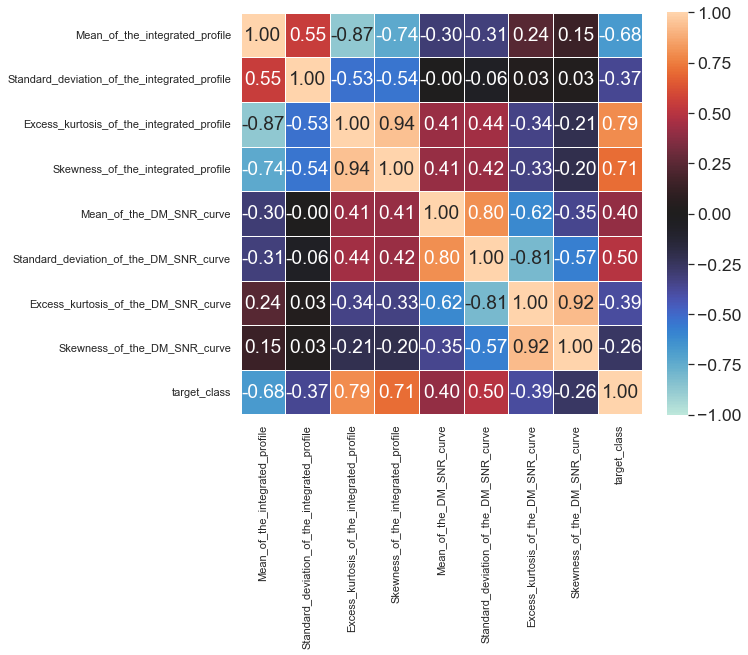

In [7]:
f, ax = plt.subplots(figsize=(9, 7.4))
sns.set(font_scale=1.6)
sns.heatmap(p_norm.corr(),annot=True,fmt = ".2f", center = 0, vmin = -1, vmax = 1,linewidths=.5, ax = ax,square = True);


From the correlation plot we learn that the highest correlation between the target class and the features is with Excess kurtosis of the integrated profile at 0.79, which is also the feature with the most missing values. So we need to be carefull on how to deal with such values. To have a bot more information about how the target class relates with the rest of the features and how do they related with each other we look at the pair plot. 

### The pair plot of each feature with the color of each data point representing the target. 

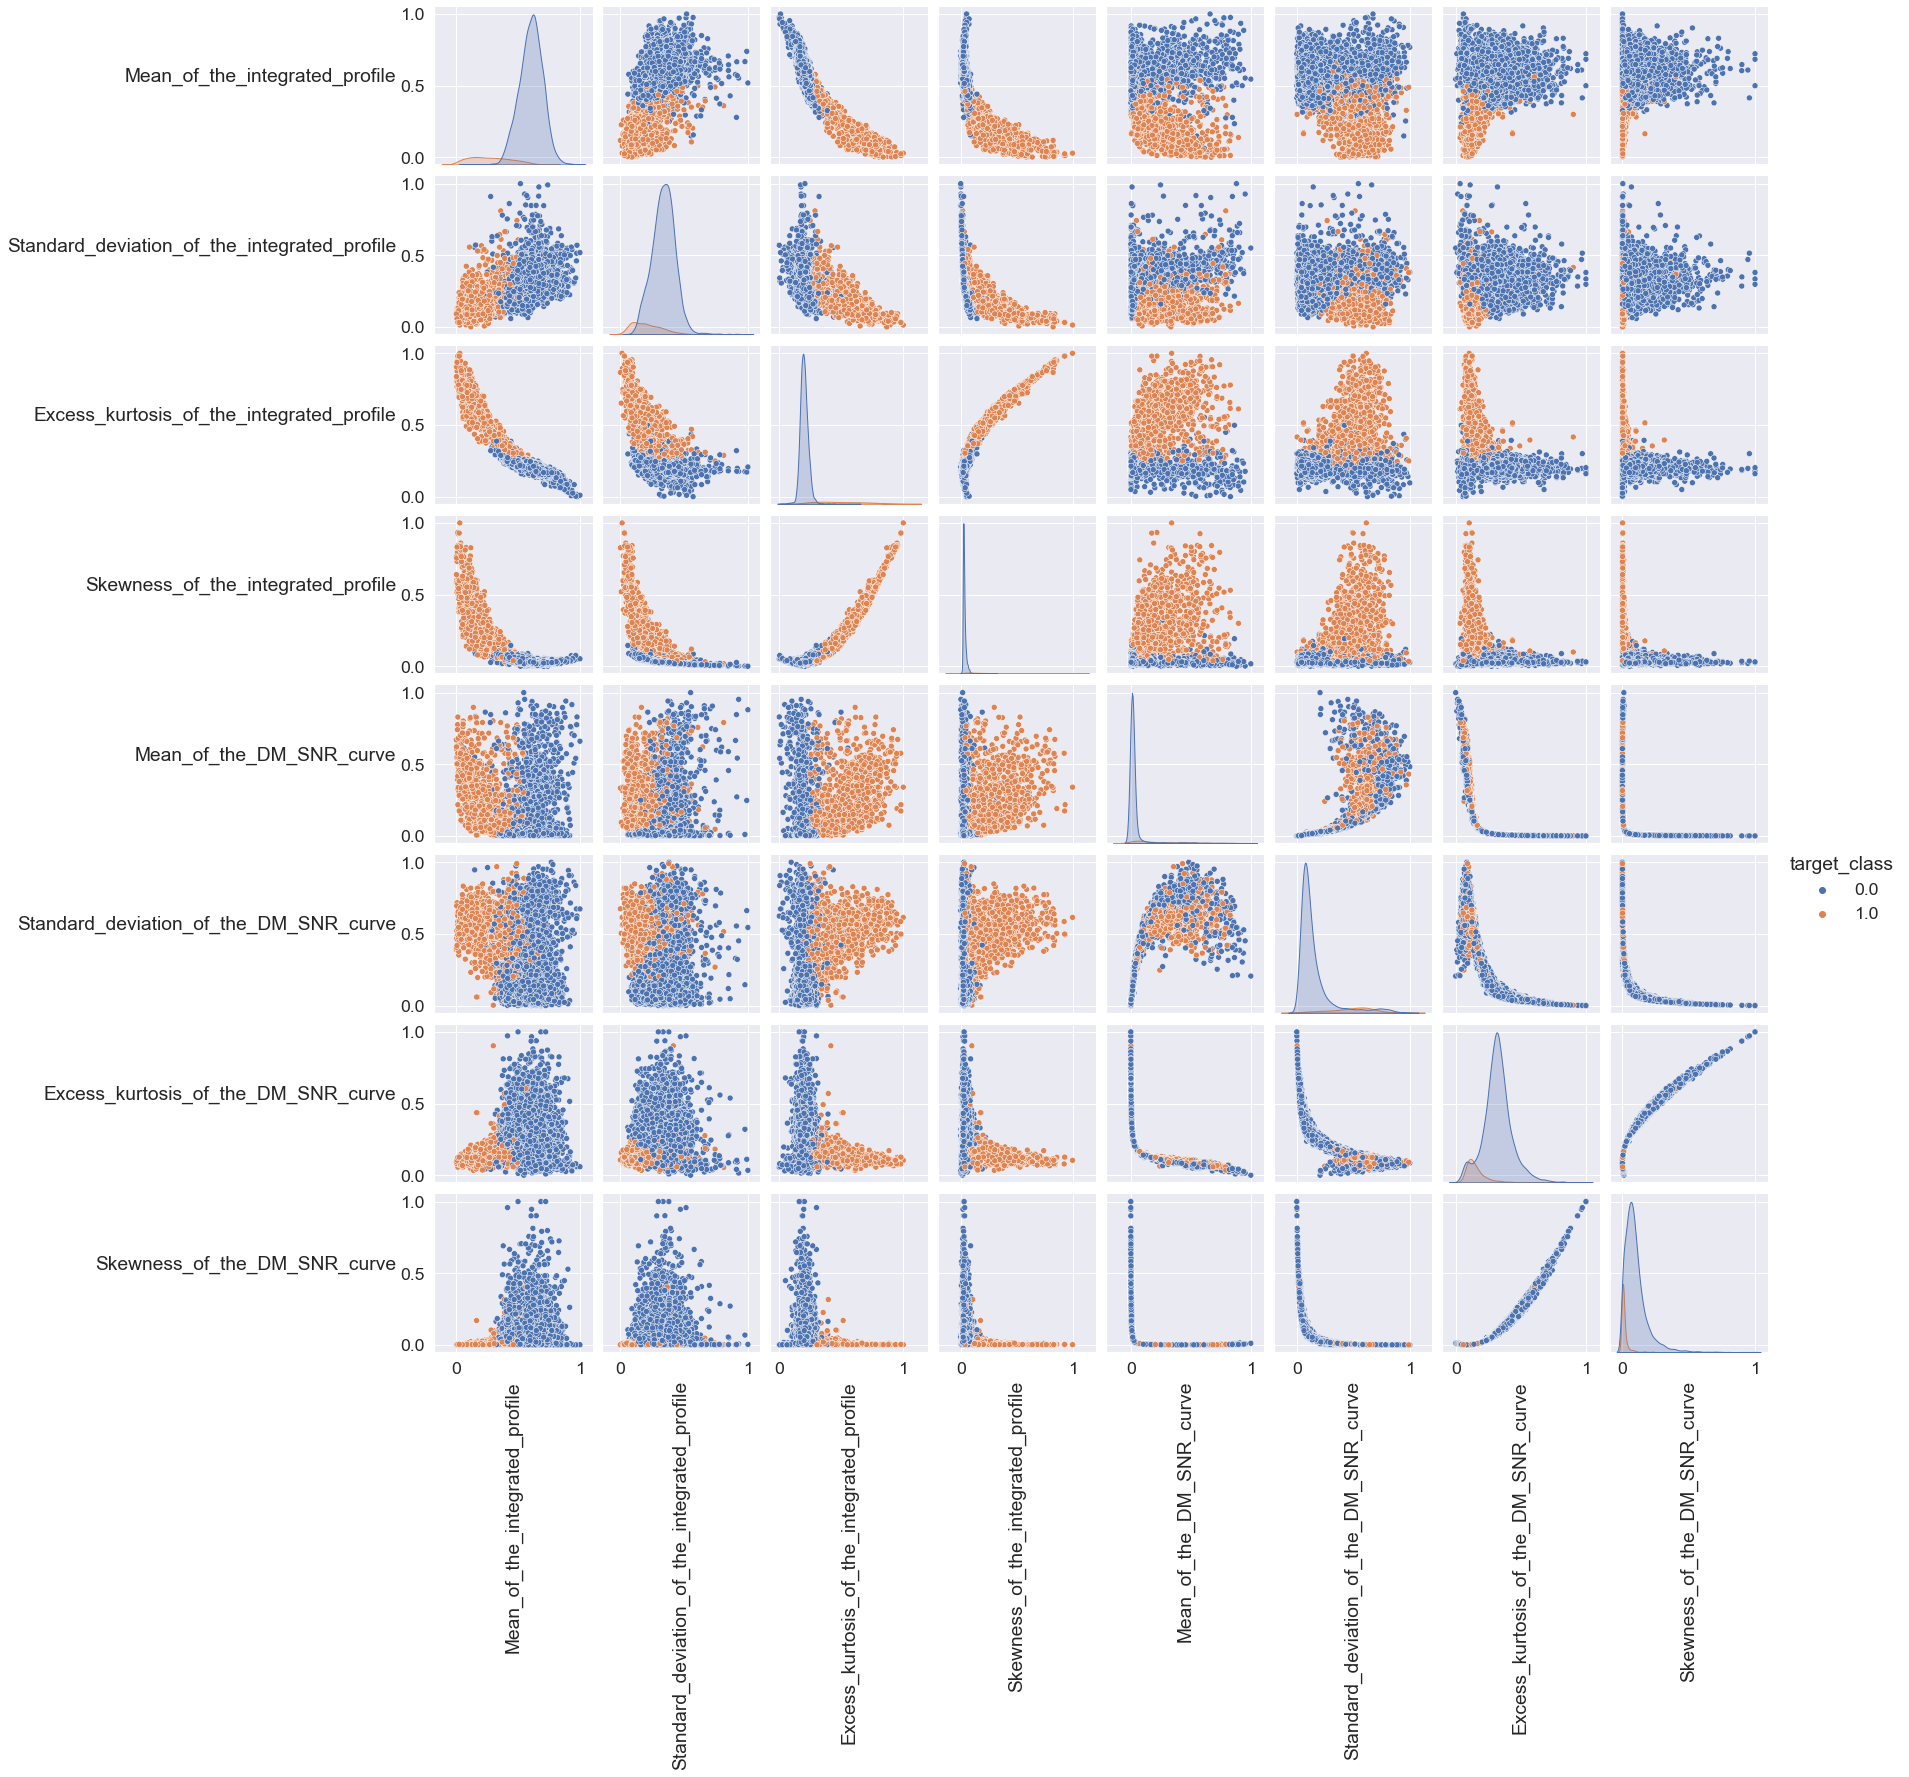

In [8]:
g = sns.pairplot(p_norm,diag_kind = 'kde', hue = 'target_class')

for ax in g.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

In the pair plot we can observe that the target class orange if =1 means its a pulsar and blue = 0 means is not, looks easier to separate in the plots by orange and blue involving the Integrated profile over the ones of the DM SNR curve. So I expect the resulting model to depend more on first 4 features. 


By rule of thumb from how many missing values each feature has,we should get rid of the Excess_kurtosis_of_the_integrated_profile as it has more than 10% of missing values, however because it is the one with the highest correlation with the target class, I will try to input the missing values by trying to see if I can fit that feature using multilinear regresion with the rest of the features from the integrated profile. 

From both the correlation and the pair plot we see that the excess kurtosis of the integrated profile is highly correlated with the skewness and the mean of the integrated profile if we look at the plot of Skweness vs Excess Kurtosis we can see the shape it's close to the square root. Let's look at the plot by itself with the color of the dots representing the standard deviation of the integrated profile to see if it's adds further information.  

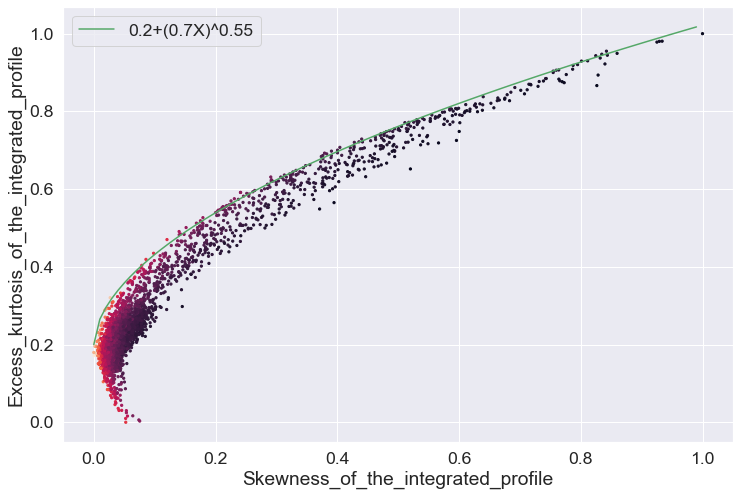

In [9]:
fig, ax = plt.subplots(figsize = (12, 8))

ax.scatter(p_norm.Skewness_of_the_integrated_profile,p_norm.Excess_kurtosis_of_the_integrated_profile,
           c = p_norm.Standard_deviation_of_the_integrated_profile, s =5)
x = np.arange(0,1,0.01)
ax.plot(x,np.power(0.7*x,0.55)+0.2,label = "0.2+(0.7X)^0.55",c = 'g')
ax.set_xlabel('Skewness_of_the_integrated_profile')
ax.set_ylabel('Excess_kurtosis_of_the_integrated_profile')
ax.legend()
plt.show()

In the plot above the color is the standar deviation of the integrated profile and we can see it does add information to the plot. The green line than envolves the data is the (0.7*Skeness)^0.55+0.2 and I got to it with trial and error by eye, so if we combine the Skewness^0.55 with the Santandar deviation and the Mean in a linear regression model we might get a good aproximation of the excess kurtosis to substitute the missing values.

### Linear Regression to get the missing Excess Kurtosis of the integrated profile.

Using the data for the integrated profile and multilinear regression I fit a model to get the missing data points for the Excess Kurtosis. 

In [10]:
X_train, X_test= train_test_split(p_norm,test_size=0.15, random_state= 47)

model = \
smf.ols(formula=\
        'Excess_kurtosis_of_the_integrated_profile~np.power(Skewness_of_the_integrated_profile,0.55)\
         +Standard_deviation_of_the_integrated_profile+Mean_of_the_integrated_profile', 
                data=X_train).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                       
=====================================================================================================
Dep. Variable:     Excess_kurtosis_of_the_integrated_profile   R-squared:                       0.972
Model:                                                   OLS   Adj. R-squared:                  0.972
Method:                                        Least Squares   F-statistic:                 1.071e+05
Date:                                       Mon, 10 Oct 2022   Prob (F-statistic):               0.00
Time:                                               12:46:17   Log-Likelihood:                 23743.
No. Observations:                                       9167   AIC:                        -4.748e+04
Df Residuals:                                           9163   BIC:                        -4.745e+04
Df Model:                                                  3                                         
Covariance Type:                                   nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              0.1457      0.002     73.202      0.000       0.142       0.150
np.power(Skewness_of_the_integrated_profile, 0.55)     0.8596      0.003    263.223      0.000       0.853       0.866
Standard_deviation_of_the_integrated_profile           0.2016      0.003     80.583      0.000       0.197       0.206
Mean_of_the_integrated_profile                        -0.2308      0.002   -100.607      0.000      -0.235      -0.226
==============================================================================
Omnibus:                     3949.735   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            62635.422
Skew:                          -1.648   Prob(JB):                         0.00
Kurtosis:                      15.374   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see from the model summary the adjusted R^2 has a pretty high value of 0.971 indicating that it is a good prediction and all the p_values for the coeficients are below 0.001. To get the adjusted R_Squared of the test data I use the function I wrote to get it in module 3. 

In [11]:
def adj_RS(model, data,dep_var):
    k = len(model.params)-1
    n = len(data[dep_var])
    dm = model.predict(data)
    RSS = sum((data[dep_var]-dm)**2)
    den_m = data[dep_var].mean()
    TSS = sum((data[dep_var]-den_m)**2)
    RS= 1-(RSS/TSS)  
    Adj_RS = 1-(((1-RS)*(n-1))/(n-k-1))
    return(Adj_RS)
test_R2a = adj_RS(model,X_test[X_test.Excess_kurtosis_of_the_integrated_profile.isnull()==False],
                  'Excess_kurtosis_of_the_integrated_profile')
print('The adjusted R square of the test data is ' + str(np.round(test_R2a,3)))

The adjusted R square of the test data is 0.971


We got a pretty good R square value for the test data too. If we plot the results of the prediction against the actual Excess Kurtosis values we get the next plot. With that target class as a color. Blue dots correspond to target class 0 while red dots corresponds to 1. A perfect prediction would be a line of slope 1 like the green line on the plot. 

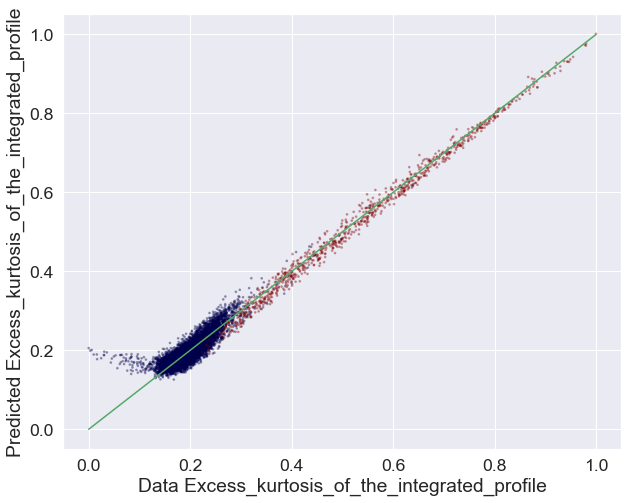

In [12]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(p_norm.Excess_kurtosis_of_the_integrated_profile,model.predict(p_norm),
           c = p_norm.target_class,s =3,alpha=0.3,cmap = 'seismic')
ax.plot(np.arange(0,1,.001),np.arange(0,1,.001),c = 'g')
ax.set_xlabel('Data Excess_kurtosis_of_the_integrated_profile')
ax.set_ylabel('Predicted Excess_kurtosis_of_the_integrated_profile')
plt.savefig('pred_plot.pdf')
plt.show()

We can see that from 0.2 to 1 the prediction is pretty good, but it brokes down for values betwenn 0 and 0.2 as expected. However it seems that for small Excess kurtosis of the integrated profile, the sign doesn't change the prediction of the result value so I will imput the missing values with the model aproximation. 



In [13]:
p_norm.loc[p_norm['Excess_kurtosis_of_the_integrated_profile'].isnull(),
           'Excess_kurtosis_of_the_integrated_profile'] = \
model.predict(p_norm[p_norm.Excess_kurtosis_of_the_integrated_profile.isnull()])

From the correlation matrix and the pair plot we see that the other 2 features with missing values don't seem to be that important to predict the target class, so we will drop the Standard_deviation_of_the_DM_SNR_curve and the missing rows of the Skewness_of_the_DM_SNR_curve that has only 5% missing.

In [14]:
p_norm = p_norm.drop(columns = ['Standard_deviation_of_the_DM_SNR_curve'])
p_norm = p_norm.dropna()

In [15]:
p_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11903 entries, 0 to 12527
Data columns (total 8 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Mean_of_the_integrated_profile                11903 non-null  float64
 1   Standard_deviation_of_the_integrated_profile  11903 non-null  float64
 2   Excess_kurtosis_of_the_integrated_profile     11903 non-null  float64
 3   Skewness_of_the_integrated_profile            11903 non-null  float64
 4   Mean_of_the_DM_SNR_curve                      11903 non-null  float64
 5   Excess_kurtosis_of_the_DM_SNR_curve           11903 non-null  float64
 6   Skewness_of_the_DM_SNR_curve                  11903 non-null  float64
 7   target_class                                  11903 non-null  float64
dtypes: float64(8)
memory usage: 836.9 KB


As the final step of the exploratory data analis and data clean up lets see how imbalanced is the target class, with the mean value of the target class. A perfectly balnced target class would have 0.5 as a mean.

In [16]:
print('Porcentage of pulsars in data '+str(np.round(100*np.mean(pulsar.target_class),0))+'%')

Porcentage of pulsars in data 9.0%


This means tha the data is a bit imbalanced as more than 90% of it is from not pulsar.

## Machine Learning Classification Problem. 

The data is now ready to solve the classification problem that will determine if a star its a pulsar or not. I will try different models and see which one works best. 
First thing to do is separate the data in train and test data. 

In [17]:
x_train,x_test, y_train, y_test = train_test_split(p_norm.loc[:, p_norm.columns != 'target_class'],
                                                   p_norm.target_class, test_size=0.30, random_state=32)


And use the functions from module 4 to evaluate the precision and recall and F1, because the data is imbalanced, we wont use only accuracy to see how well the models do. As a model that predict 0 always would have a 0.91 Accuracy.  In this case I will look for the best F1 to tune the models parameters or hyperparameters. As F1 contains both precision and recall, so it tells if we are either missing to many positive values or overpredicting too many positive values. We want to find some balance as we dont want to give to many not pulsars to evaluate them as pulsar neither miss too many good candidates. 

In [18]:
## Functions to calculate evalution metrics. 

def calculate_precision(y_true, y_pred, pos_label_value=1.0):
    '''
    This function accepts the labels and the predictions, then
    calculates precision for a binary classifier.
    
    Args
        y_true: np.ndarray
        y_pred: np.ndarray
        
        pos_label_value: (float) the number which represents the postiive
        label in the y_true and y_pred arrays. Other numbers will be taken
        to be the non-positive class for the binary classifier.
    
    Returns precision as a floating point number between 0.0 and 1.0
    '''
    
    
    # your code here
    #precision is True Positive/(True Positives + False Positives)
    TP = sum(y_true == pos_label_value)
    #Check if y_pred == pos_label_value when y_true is not to get false positives
    FP = sum(y_pred[(y_true!=pos_label_value)]==pos_label_value)
    
    
    return TP/(TP+FP)

def calculate_recall(y_true, y_pred, pos_label_value=1.0):
    '''
    This function accepts the labels and the predictions, then
    calculates recall for a binary classifier.
    
    Args
        y_true: np.ndarray
        y_pred: np.ndarray
        
        pos_label_value: (float) the number which represents the postiive
        label in the y_true and y_pred arrays. Other numbers will be taken
        to be the non-positive class for the binary classifier.
    
    Returns precision as a floating point number between 0.0 and 1.0
    '''
    
    # your code here
    #Recall is TP/(TP+FN)
    TP = sum(y_true == pos_label_value)
    FN = sum(y_pred[(y_true == pos_label_value)]!=pos_label_value)

                    
    
    return TP/(TP+FN)

def calculate_FPR(y_true, y_pred, pos_label_value=1.0):
    #FPR is FP/N(data)
    FP = sum(y_pred[y_true!=pos_label_value]==pos_label_value)
    return(FP/len(y_true))

def calculate_FNR(y_true,y_pred,pos_label_value = 1.0):
    #FN/n(data)
    FN = sum(y_pred[y_true==pos_label_value]!=pos_label_value)
    return (FN/len(y_true))

def cal_F1(y_true,y_pred,pos_value = 1.0):
    return calculate_precision(y_true,y_pred)+calculate_recall(y_true,y_pred) 

I will fit 7 different classifiers to the data and compare its evaluation metrics. 
The classifiers will be:
1. Logistic Regression
2. K-Neiarest Neighbors
3. Decision Tree 
4. Random Forest 
5. Extra Tree
6. AdaBoost
7. Linear Support Vector.


The evaluation metrics to compare them will be:
- The mean cross validation Accuracy.
- Precision
- Recall
- F1, harmonic mean between precision and Recall.
- The AUC score from the ROC curve
- The False Positive Rate. 

For each classifier I will use the sklearn function of the classifier, fit it with the train data and do a parameter or hyperparameter search to get the "best" clasifier, I will the use such classifier to predict the test data, and when the model allows it to also get the predicted probability of the test data in order to get the ROC curve.  I will also show the confusion matrix of each classifier in order to see how many data points wher missclasified and how for each model. 

In [19]:
#Create a data frame to store all the metrics from the diferent classifiers. 
#pd.DataFrame(0, index=np.arange(len(data)), columns=feature_list)
comparison = pd.DataFrame(0,index = ['Mean_CV_Accuracy','Precision','Recall','F1','AUC','FPR'],
                          columns = ['LR','KNN','DT','RF','ET','AB','SVL'], )


### Logistic regresion.

We start by fitting a simple logistic regression model with the train data specifing the class weight as balanced due to the imbalance on our data.  

In [20]:
#We call and fit the logistic regresion model and display 
#the coeficients of each feature in the model. 
LogReg = LogisticRegression(class_weight='balanced',max_iter=100).fit(x_train,y_train)
display(pd.DataFrame(LogReg.coef_,columns = x_test.columns.values))


,Mean_of_the_integrated_profile,Standard_deviation_of_the_integrated_profile,Excess_kurtosis_of_the_integrated_profile,Skewness_of_the_integrated_profile,Mean_of_the_DM_SNR_curve,Excess_kurtosis_of_the_DM_SNR_curve,Skewness_of_the_DM_SNR_curve
0,-7.154294,-0.163243,13.751474,3.4267,-0.4164,-6.860064,-2.86215


As expected the most important feature in the logisitic regression, that is the one with the largest coeficient in the logistic regresion model was the Escess Kurtosis of the integrated profile. 

To evaluate how well the model did we calculate the precision, the recall, the ROC curve and the confusion matrix. 

Presicion is 0.75
Recall is 0.885
F1, the harmonic mean of precision and recall is 1.635


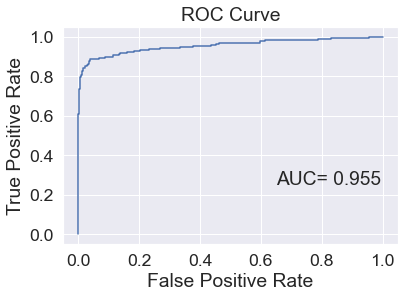

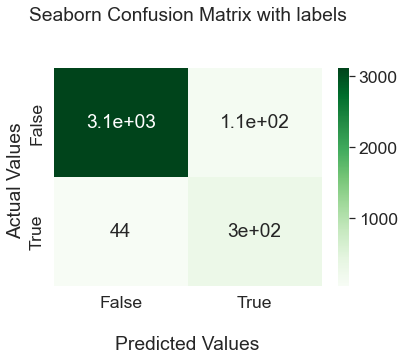

In [21]:
#We get the predicted target and the probability of the target to calculate the evaluation metrics
#And see the ROC curve. 
ypp = LogReg.predict_proba(x_test)
y_pred = LogReg.predict(x_test)

# Calculate the evaluation metrics. 
pres = calculate_precision(y_test,y_pred)
rec = calculate_recall (y_test,y_pred)
F1 = cal_F1(y_test,y_pred)
FPR = calculate_FPR(y_test,y_pred)
print("Presicion is " + str(np.round(pres,3)))
print("Recall is " + str(np.round(rec,3)))
print("F1, the harmonic mean of precision and recall is " + str(np.round(F1,3)))

#Calculate the roc curve from module 3.
fpr,tpr,th = roc_curve(y_test,ypp[:,1])
auc = roc_auc_score(y_test,ypp[:,1])
plt.plot(fpr,tpr,"-")
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.65,0.25,'AUC= '+"{:.3f}".format(auc));
plt.show()

cf_matrix = confusion_matrix(y_test,y_pred)
#Confusion matrix plot from https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [22]:
comparison['LR']=(np.round(np.mean(cross_val_score(LogReg, x_train, y_train, cv=3)),4),
                  np.round(pres,4),np.round(rec,4),np.round(F1,4),
                  np.round(auc,4),np.round(FPR,4))

The ROC curve shows the model works pretty well. However it seems like we are over predicting the True values. Lets see if further models get us a better F1. 

### KNN model

Given that the number of features is not big and that we already scaled all the features we can try a KNN model to se how it performs against the rest. We will explore the number of neighbors to find the best knn classifier. 

In [23]:
neighs = [] #K neigh clasifiers for diferents ns
ns = np.arange(5,80,2)
for n in ns :
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(x_train,y_train)
    neighs.append(neigh)

    
train_F1 = []
test_F1 = []


train_F1 = [cal_F1(y_train, clf.predict(x_train)) for clf in neighs]
test_F1 = [cal_F1(y_test, clf.predict(x_test)) for clf in neighs]


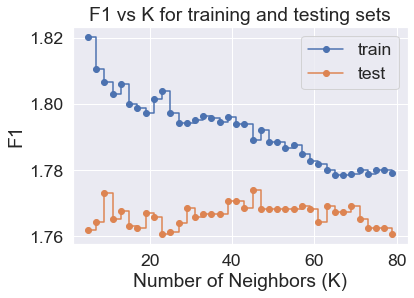

In [24]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Neighbors (K)")
ax.set_ylabel("F1")
ax.set_title("F1 vs K for training and testing sets")
ax.plot(ns, train_F1, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ns, test_F1, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show() 

In [25]:
ia = np.where(test_F1 == max(test_F1))[0][0]
print('The knn classifier with the best F1 has ' + str(ns[ia])+" neighbors")
neigh = neighs[ia]


The knn classifier with the best F1 has 45 neighbors


In [26]:
neighcv = KNeighborsClassifier(n_neighbors=ns[ia])
print('The accuracy of the KNN classifier with ' +str(ns[ia])+ ' neighbors is '+\
      str(np.round(np.mean(cross_val_score(neighcv, x_train, y_train, cv=3)),3)))

y_pred = neigh.predict(x_test)
ypp= neigh.predict_proba(x_test)


The accuracy of the KNN classifier with 45 neighbors is 0.976


Presicion is 0.963
Recall is 0.811
F1, the harmonic mean of precision and recall is 1.774


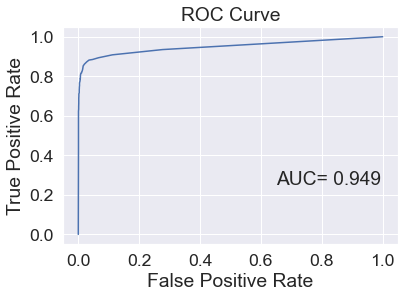

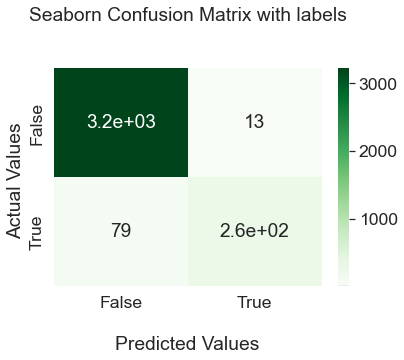

In [27]:
pres = calculate_precision(y_test,y_pred)
rec = calculate_recall (y_test,y_pred)
F1 = cal_F1(y_test,y_pred)
FPR = calculate_FPR(y_test,y_pred)
print("Presicion is " + str(np.round(pres,3)))
print("Recall is " + str(np.round(rec,3)))
print("F1, the harmonic mean of precision and recall is " + str(np.round(F1,3)))

#Calculate the roc curve from module 3.
fpr,tpr,th = roc_curve(y_test,ypp[:,1])
auc = roc_auc_score(y_test,ypp[:,1])
plt.plot(fpr,tpr,"-")
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.65,0.25,'AUC= '+"{:.3f}".format(auc));
plt.show()

cf_matrix = confusion_matrix(y_test,y_pred)
#Confusion matrix plot from https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

The KNN model had a better precision than the logistic regresion as the number of false positives it gives is small. However it has more false negatives, this means we miss more true positives of pulsar candidates. 

In [28]:
comparison['KNN']=(np.round(np.mean(cross_val_score(neigh, x_train, y_train, cv=3)),4),
                  np.round(pres,4),np.round(rec,4),np.round(F1,4),
                  np.round(auc,4),np.round(FPR,4))

### Decision Tree

A simple decision tree and prune it for differents alphas, like we did in Module 4. 

In [29]:
DT = DecisionTreeClassifier(max_depth=12, class_weight='balanced').fit(x_train,y_train)

We prune for a range of alphas and find the accuracy for each alpha.

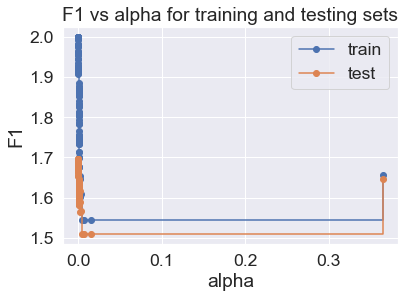

In [30]:
path = DT.cost_complexity_pruning_path(x_train,y_train) #post pruning
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = [] # VECTOR CONTAINING CLASSIFIERS FOR DIFFERENT ALPHAS
# TODO: iterate over ccp_alpha values 
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(class_weight='balanced',random_state=40, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
    
train_F1 = []
test_F1 = []


train_F1 = [cal_F1(y_train, clf.predict(x_train)) for clf in clfs]
test_F1 = [cal_F1(y_test, clf.predict(x_test)) for clf in clfs]



fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("F1")
ax.set_title("F1 vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_F1, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_F1, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show() 

We choose the alpha where the test F1 is the largest.  


In [31]:
ia = np.where(test_F1 == max(test_F1))[0][-1]
BT = clfs[ia]

print('The depth of the tree is ' + str(BT.get_depth()))
print('The alpha used to prune the tree is ' + str(np.round(ccp_alphas[ia],4)))


The depth of the tree is 18
The alpha used to prune the tree is 0.0001


In [32]:
clf = DecisionTreeClassifier(class_weight='balanced',random_state=40, ccp_alpha=ccp_alphas[ia])
print('The accuracy of the Decision Tree classifier is ' +\
      str(np.round(np.mean(cross_val_score(clf, x_train, y_train, cv=3)),3)))

y_pred = BT.predict(x_test)
ypp= BT.predict_proba(x_test)

The accuracy of the Decision Tree classifier is 0.971


Presicion is 0.845
Recall is 0.85
F1, the harmonic mean of precision and recall is 1.695


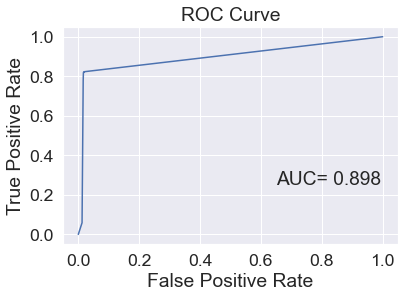

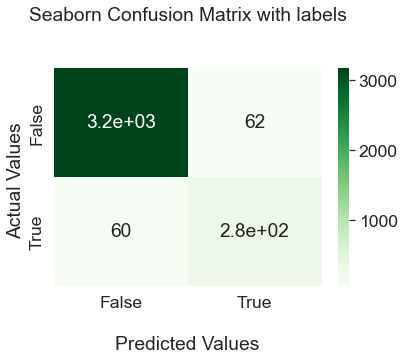

In [33]:
pres = calculate_precision(y_test,y_pred)
rec = calculate_recall (y_test,y_pred)
F1 = cal_F1(y_test,y_pred)
FPR = calculate_FPR(y_test,y_pred)
print("Presicion is " + str(np.round(pres,3)))
print("Recall is " + str(np.round(rec,3)))
print("F1, the harmonic mean of precision and recall is " + str(np.round(F1,3)))

#Calculate the roc curve from module 3.
fpr,tpr,th = roc_curve(y_test,ypp[:,1])
auc = roc_auc_score(y_test,ypp[:,1])
plt.plot(fpr,tpr,"-")
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.65,0.25,'AUC= '+"{:.3f}".format(auc));
plt.show()

cf_matrix = confusion_matrix(y_test,y_pred)
#Confusion matrix plot from https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

With this very deep decision tree we improved the precision and the F1 values over the Logistic regression model results but the recall and AUC value decreased. In other words the False Positives decreased but the False Negatives increased, meaning with the decision tree we miss out on pulsar candidates. 

Even with the prunning we got a pretty big the Decision Tree in order to get a better F1 metric than for logistic regresion the depth is 18. Such a deep tree usually overfits and we dint get the simplicity of a shaloow Decision Tree. 
A Decision tree ensemble method, with small trees could give better results

In [34]:
comparison['DT']=(np.round(np.mean(cross_val_score(DT, x_train, y_train, cv=3)),4),
                  np.round(pres,4),np.round(rec,4),np.round(F1,4),
                  np.round(auc,4),np.round(FPR,4))

### Ensemble trees.

#### Random Forest Classifier

A Random Forest Classifier like the one we saw in module 5,  with trees of max depth of 2, and using only 5% of the sample to train each tree. 

In [35]:
RF = RandomForestClassifier(max_depth = 2, class_weight = 'balanced_subsample',
                            max_samples = 0.05, random_state= 57)
print('The accuracy of the random forest is ' +\
      str(np.round(np.mean(cross_val_score(RF, x_train, y_train, cv=3)),3)))
RF.fit(x_train,y_train)

The accuracy of the random forest is 0.974


RandomForestClassifier(class_weight='balanced_subsample', max_depth=2,
                       max_samples=0.05, random_state=57)

Presicion is 0.878
Recall is 0.86
F1, the harmonic mean of precision and recall is 1.739


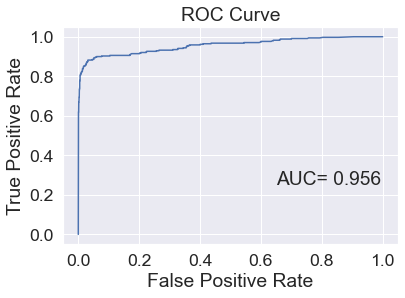

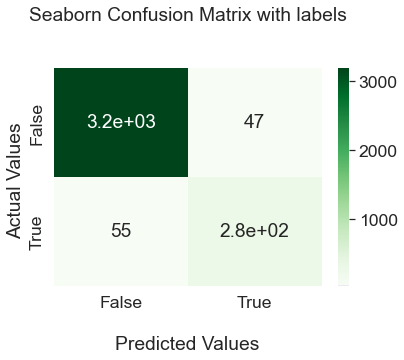

In [36]:
y_pred = RF.predict(x_test)
ypp =RF.predict_proba(x_test)
pres = calculate_precision(y_test,y_pred)
rec = calculate_recall (y_test,y_pred)
F1 = cal_F1(y_test,y_pred)
FPR = calculate_FPR(y_test,y_pred)
print("Presicion is " + str(np.round(pres,3)))
print("Recall is " + str(np.round(rec,3)))
print("F1, the harmonic mean of precision and recall is " + str(np.round(F1,3)))

#Calculate the roc curve from module 3.
fpr,tpr,th = roc_curve(y_test,ypp[:,1])
auc = roc_auc_score(y_test,ypp[:,1])
plt.plot(fpr,tpr,"-")
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.65,0.25,'AUC= '+"{:.3f}".format(auc));
plt.show()

cf_matrix = confusion_matrix(y_test,y_pred)
#Confusion matrix plot from https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [37]:
comparison['RF']=(np.round(np.mean(cross_val_score(RF, x_train, y_train, cv=3)),4),
                  np.round(pres,4),np.round(rec,4),np.round(F1,4),
                  np.round(auc,4),np.round(FPR,4))

#### Extra Tree Classifier

An extra tree classifier or Extremely Randomized Trees, is similar to a random forest, with 2 differences, The basic extra tree algorithm uses all the train data in each decision tree, while the random forest bootstraps and uses samples, the second and more important difference is that the extra tree chooses the cut point to make the tree randomly, while the random forest chooses the optimum split. (https://quantdare.com/what-is-the-difference-between-extra-trees-and-random-forest/ ) becuase of it, the extra tree algorithm is faster than the random forest. Let's try it out and maybe even use more samples to create our classificator as it's faster. 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html?highlight=ensemble+extra+tree+classifier

In [38]:
ETC = ExtraTreesClassifier(n_estimators=100, class_weight = 'balanced',random_state=12)
print('The accuracy of the Extra Tree Classifier is ' +\
      str(np.round(np.mean(cross_val_score(ETC, x_train, y_train, cv=3)),4)))

ETC.fit(x_train, y_train)

The accuracy of the Extra Tree Classifier is 0.9797


ExtraTreesClassifier(class_weight='balanced', random_state=12)

Presicion is 0.934
Recall is 0.843
F1, the harmonic mean of precision and recall is 1.777


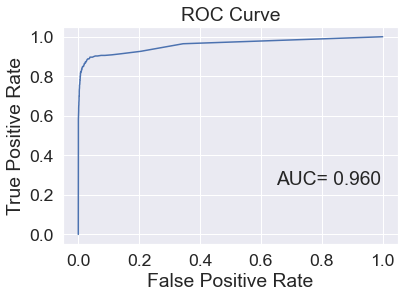

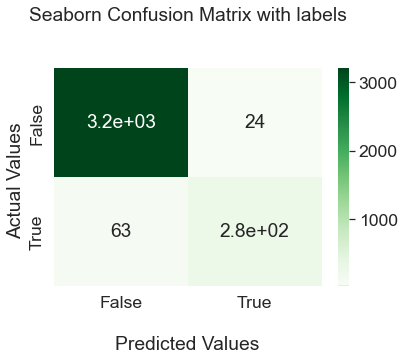

In [39]:
y_pred = ETC.predict(x_test)
ypp =ETC.predict_proba(x_test)
pres = calculate_precision(y_test,y_pred)
rec = calculate_recall (y_test,y_pred)
F1 = cal_F1(y_test,y_pred)
FPR = calculate_FPR(y_test,y_pred)
print("Presicion is " + str(np.round(pres,3)))
print("Recall is " + str(np.round(rec,3)))
print("F1, the harmonic mean of precision and recall is " + str(np.round(F1,3)))

#Calculate the roc curve from module 3.
fpr,tpr,th = roc_curve(y_test,ypp[:,1])
auc = roc_auc_score(y_test,ypp[:,1])
plt.plot(fpr,tpr,"-")
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.65,0.25,'AUC= '+"{:.3f}".format(auc));
plt.show()

cf_matrix = confusion_matrix(y_test,y_pred)
#Confusion matrix plot from https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [40]:
comparison['ET']=(np.round(np.mean(cross_val_score(ETC, x_train, y_train, cv=3)),4),
                  np.round(pres,4),np.round(rec,4),np.round(F1,4),
                  np.round(auc,4),np.round(FPR,4))

#### AdaBoost Classifier

Lets try a boosted ensemble method like adaboost we saw in module 5. 

In [41]:
AB = AdaBoostClassifier(n_estimators=100, random_state=25)
print('The accuracy of the AdaBoost Classifier is ' +\
      str(np.round(np.mean(cross_val_score(AB, x_train, y_train, cv=3)),4)))

AB.fit(x_train, y_train)

The accuracy of the AdaBoost Classifier is 0.9796


AdaBoostClassifier(n_estimators=100, random_state=25)

Presicion is 0.931
Recall is 0.843
F1, the harmonic mean of precision and recall is 1.775


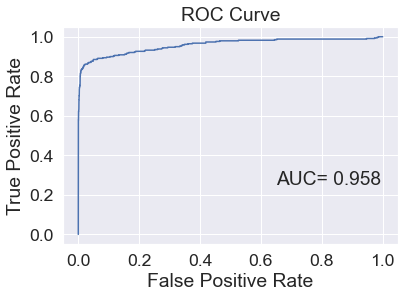

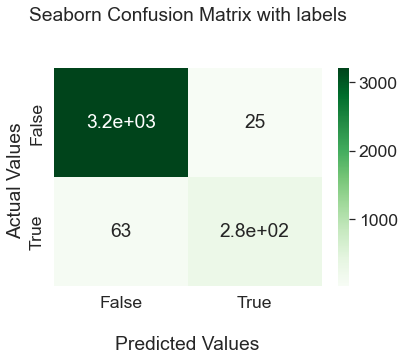

In [42]:
y_pred = AB.predict(x_test)
ypp =AB.predict_proba(x_test)
pres = calculate_precision(y_test,y_pred)
rec = calculate_recall (y_test,y_pred)
F1 = cal_F1(y_test,y_pred)
FPR = calculate_FPR(y_test,y_pred)
print("Presicion is " + str(np.round(pres,3)))
print("Recall is " + str(np.round(rec,3)))
print("F1, the harmonic mean of precision and recall is " + str(np.round(F1,3)))

#Calculate the roc curve from module 3.
fpr,tpr,th = roc_curve(y_test,ypp[:,1])
auc = roc_auc_score(y_test,ypp[:,1])
plt.plot(fpr,tpr,"-")
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.65,0.25,'AUC= '+"{:.3f}".format(auc));
plt.show()

cf_matrix = confusion_matrix(y_test,y_pred)
#Confusion matrix plot from https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [43]:
comparison['AB']=(np.round(np.mean(cross_val_score(AB, x_train, y_train, cv=3)),4),
                  np.round(pres,4),np.round(rec,4),np.round(F1,4),
                  np.round(auc,4),np.round(FPR,4))

### Support vector Machine.

From the pair plot looked like they could be a linear boundary so lets try a linear Support Vector Machine and do a grid search for the best parameter c. 

In [44]:
#We set the variation in the C parameter. 
parameters = {'C':np.arange(1,12)}
#We create a scorer so the grid search looks for the best F1.
F1_scorer = make_scorer(cal_F1)
lsvc = LinearSVC(loss ='squared_hinge')
lss = GridSearchCV(lsvc, parameters, scoring=F1_scorer, cv = 3)
grid = lss.fit(x_train, y_train)


In [45]:
print('The best parameters for the linear Suppport vector classifier is ' +\
str(grid.best_params_))
print('The accuracy of the Linear SV Classifier is ' + str(np.round(grid.best_score_,4)))
lsvcf = grid.best_estimator_

The best parameters for the linear Suppport vector classifier is {'C': 11}
The accuracy of the Linear SV Classifier is 1.795


Linear suport vector doesn't give you the probability of getting the target class, as the decision making is not by probabilities but by set boundaries, because of it there is no ROC curve or AUC value for this classifier. 

Presicion is 0.96
Recall is 0.815
F1, the harmonic mean of precision and recall is 1.775


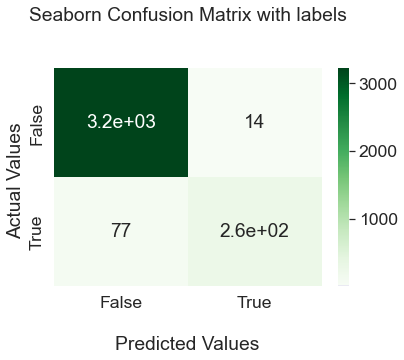

In [46]:
y_pred = lsvcf.predict(x_test)
pres = calculate_precision(y_test,y_pred)
rec = calculate_recall (y_test,y_pred)
F1 = cal_F1(y_test,y_pred)
FPR = calculate_FPR(y_test,y_pred)
print("Presicion is " + str(np.round(pres,3)))
print("Recall is " + str(np.round(rec,3)))
print("F1, the harmonic mean of precision and recall is " + str(np.round(F1,3)))


cf_matrix = confusion_matrix(y_test,y_pred)
#Confusion matrix plot from https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [47]:
comparison['SVL']=(np.round(np.mean(cross_val_score(lsvcf, x_train, y_train, cv=3)),4),
                  np.round(pres,4),np.round(rec,4),np.round(F1,4),
                  None,np.round(FPR,4))

## Results 

This is the final table comparing the evalution metrics of each classifier. 

In [48]:
comp = comparison.transpose().reset_index().rename(columns={"index":"Class"})
comp

,Class,Mean_CV_Accuracy,Precision,Recall,F1,AUC,FPR
0,LR,0.9587,0.7500,0.8851,1.6351,0.9546,0.0316
1,KNN,0.9760,0.9631,0.8110,1.7741,0.9493,0.0036
2,DT,0.9677,0.8454,0.8496,1.6950,0.8985,0.0174
3,RF,0.9744,0.8782,0.8604,1.7386,0.9559,0.0132
4,ET,0.9797,0.9339,0.8433,1.7772,0.9597,0.0067
5,AB,0.9796,0.9313,0.8433,1.7746,0.9579,0.0070
6,SVL,0.9782,0.9603,0.8149,1.7752,NaN,0.0039


First we see the difference in values in the AUC for all but the SVL. 

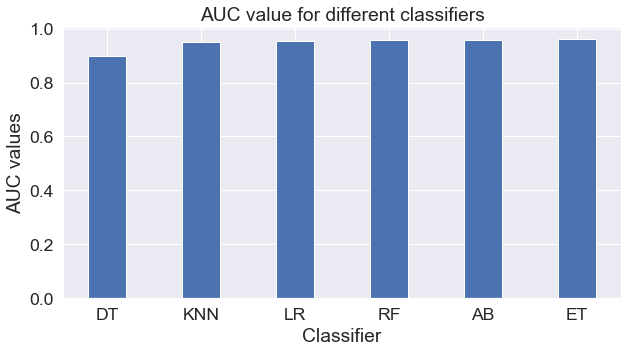

In [49]:
comps = comp.sort_values(by = 'AUC')

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(comps.Class, comps.AUC,
        width = 0.4)
 
plt.xlabel("Classifier")
plt.ylabel("AUC values")
plt.title("AUC value for different classifiers")
plt.show()

The Extra Tree classifier achieved the best AUC values, however the difference with all but the single Decision Tree is neglible as they are all around 0.95

We can visualize the rest of the evalution metrics in a parallel plot where the color of the line indicates the classifier and each vertical axis correspond to a evaluation metric. 

In [50]:
base = alt.Chart(comp).transform_window(
    index="count()"
).transform_fold(
    ['Mean_CV_Accuracy', 'Precision', 'Recall','FPR','F1']
).transform_joinaggregate(
    min="min(value)",
    max="max(value)",
    groupby=["key"]
).transform_calculate(
    norm_val="(datum.value - datum.min) / (datum.max - datum.min)",
    mid="(datum.min + datum.max) / 2"
).properties(width=600, height=300)

lines = base.mark_line(opacity=0.6).encode(
    x='key:N',
    y=alt.Y('norm_val:Q', axis=None),
    color="Class:N",
    detail="index:N",
    tooltip=["Mean_CV_Accuracy:N", "Precision:N", "Recall:N", "FPR:N","F1:N"]
)

rules = base.mark_rule(
    color="#ccc", tooltip=None
).encode(
    x="key:N",
    detail="count():Q",
)

def ytick(yvalue, field):
    scale = base.encode(x='key:N', y=alt.value(yvalue), text=f"min({field}):Q")
    return alt.layer(
        scale.mark_text(baseline="middle", align="right", dx=-5, tooltip=None),
        scale.mark_tick(size=8, color="#ccc", orient="horizontal", tooltip=None)
    )

alt.layer(
    lines, rules, ytick(0, "max"), ytick(150, "mid"), ytick(300, "min")
).configure_axisX(
    domain=False, labelAngle=0, tickColor="#ccc", title=None
).configure_view(
    stroke=None
)

alt.LayerChart(...)

The choice of classifier will depend on what its more important for us when predicting pulsar candidates, if the intended result is to miss as little pulsar candidates as posible then the Logistic Regression model is the best bet as it has the highest recall of all the classifiers. However if that was the metric we where after we would have to repeat the parameter and hyper parameter search for all the models using recall as the scoring. 
Here I focused on the best balance of results meaning the highest F1, so It wouldnt miss too many pulsar candidates but also wouldnt get too many false positives that would be a waist of resources looking at posible pulsars where they don't exist.  In the F1 race the biggest looser was the Logistic Regression classifier with a value of ~1.6. The decision tree and the Random Forest are around 1.7 and the other 4 models have really close F1 values around 1.8. 

If what we care the most is precision KNN and Linear Support Vector got the best results here with values around 0.96, but the ensemble methods Extra Tree and Ababoost allso had presicion results above 0.9. 



## Conclusions

All the classificators based on different models did better than the trivial all negative or random 1/10 target. And depending on what we wanted we could choose a different model. 
I would say the 7 models worked pretty well. 

The main decisions to get to this results where in the data imputing, I would like to see what happende if instead of getting the missing values of the excess kurtosis from the other features I would have erased the column, or deleting the instances with missing values. However I choosed this as it could have been posible for the test data be missing the excess kurtosis and from the correlation matrix looked like a really important feature in the prediction of the target class. 